In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import os
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
from gammapy.spectrum import (
    SpectrumDatasetOnOff,
    SpectrumDataset,
    SpectrumDatasetMaker,
    FluxPointsEstimator,
    FluxPointsDataset,
    ReflectedRegionsBackgroundMaker,
    plot_spectrum_datasets_off_regions,
)
from gammapy.modeling import Fit, Parameter
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SpectralModel,
    SkyModel,
    ExpCutoffPowerLawSpectralModel,
)
from gammapy.irf import load_cta_irfs
from gammapy.data import Observation
from gammapy.maps import MapAxis
from itertools import combinations

In [3]:
import scipy.stats as stats
import math
import statistics

In [4]:
os.environ['CALDB'] = '/home/rishank/anaconda2/envs/cta/share/caldb/'
!echo $CALDB
!ls $CALDB

/home/rishank/anaconda2/envs/cta/share/caldb/
data


In [5]:
irfs = load_cta_irfs(
    "$CALDB/data/cta/prod3b-v2/bcf/South_z20_50h/irf_file.fits"
)

In [6]:
livetime = 5 * u.h
n_obs = 200
pointing = SkyCoord(0, 0, unit="deg", frame="galactic")
offset = 0.5 * u.deg
# Reconstructed and true energy axis
energy_axis = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 10), unit="TeV", name="energy", interp="log"
)
energy_axis_true = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 10), unit="TeV", name="energy", interp="log"
)

on_region_radius = Angle("0.11 deg")
on_region = CircleSkyRegion(center=pointing, radius=on_region_radius)

In [7]:
# Define spectral model - a simple Power Law in this case
model_simu = PowerLawSpectralModel(
    index=2.22,
    amplitude=1.289e-12 * u.Unit("cm-2 s-1 TeV-1"),
    reference=1 * u.TeV,
)
print(model_simu)
# we set the sky model used in the dataset
model = SkyModel(spectral_model=model_simu)

PowerLawSpectralModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True


In [8]:
obs = Observation.create(pointing=pointing, livetime=livetime, irfs=irfs)
print(obs)

Info for OBS_ID = 1
- Pointing pos: RA 266.40 deg / Dec -28.94 deg
- Livetime duration: 18000.0 s



In [9]:
# Make the SpectrumDataset
dataset_empty = SpectrumDataset.create(
    e_reco=energy_axis.edges, e_true=energy_axis_true.edges, region=on_region
)
maker = SpectrumDatasetMaker(selection=["aeff", "edisp", "background"])
dataset = maker.run(dataset_empty, obs)

In [10]:
# Set the model on the dataset, and fake
dataset.model = model
dataset.fake(random_state=42)
print(dataset)

SpectrumDataset

    Name                            : 1 

    Total counts                    : 2108 
    Total predicted counts          : nan
    Total background counts         : 2115.56

    Effective area min              : 5.09e+04 m2
    Effective area max              : 5.15e+06 m2

    Livetime                        : 1.80e+04 s

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : cash
    Fit statistic value (-2 log(L)) : nan

    Number of parameters            : 0
    Number of free parameters       : 0




In [11]:
dataset_onoff = SpectrumDatasetOnOff(
    aeff=dataset.aeff,
    edisp=dataset.edisp,
    models=model,
    livetime=livetime,
    acceptance=1,
    acceptance_off=5,
)
dataset_onoff.fake(background_model=dataset.background)
print(dataset_onoff)

SpectrumDatasetOnOff

    Name                            :  

    Total counts                    : 4003 
    Total predicted counts          : 3974.28
    Total off counts                : 10646.00

    Total background counts         : 2129.20

    Effective area min              : 5.09e+04 m2
    Effective area max              : 5.15e+06 m2

    Livetime                        : 5.00e+00 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.58

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0



In [12]:
%%time

datasets = []

for idx in range(n_obs):
    dataset_onoff.fake(random_state=idx, background_model=dataset.background)
    dataset_onoff.name = f"obs_{idx}"
    datasets.append(dataset_onoff.copy())

CPU times: user 666 ms, sys: 7.13 ms, total: 673 ms
Wall time: 673 ms


Text(0, 0.5, 'No. of observations')

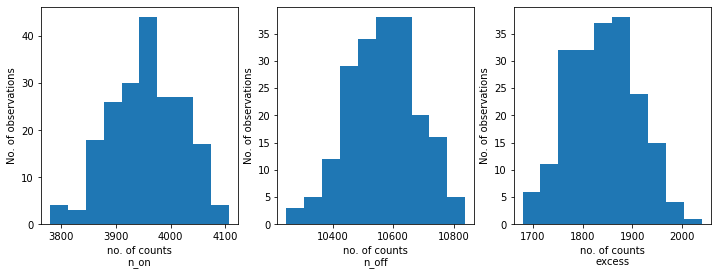

In [13]:
n_on = [dataset.counts.data.sum() for dataset in datasets]
n_off = [dataset.counts_off.data.sum() for dataset in datasets]
excess = [dataset.excess.data.sum() for dataset in datasets]

fix, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].hist(n_on)
axes[0].set_xlabel("no. of counts\nn_on")
axes[0].set_ylabel("No. of observations")
axes[1].hist(n_off)
axes[1].set_xlabel("no. of counts\nn_off")
axes[1].set_ylabel("No. of observations")
axes[2].hist(excess)
axes[2].set_xlabel("no. of counts\nexcess");
axes[2].set_ylabel("No. of observations")

In [14]:
%%time
results = []
fpes = []
e_edges = np.logspace(-1.5, 2.0, 10) * u.TeV
model_best_joints = []
for dataset in datasets:
    dataset.models = model.copy()
    fit = Fit([dataset])
    result = fit.run()
    results.append(
        {
            "index": result.parameters["index"].value,
            "amplitude": result.parameters["amplitude"].value,
            "reference":result.parameters["reference"].value,
        }
    )
    print(result.parameters.to_table())
    fpe = FluxPointsEstimator(datasets=[dataset], e_edges=e_edges)
    flux_points = fpe.run()
    print(flux_points.table_formatted)
    fpes.append(flux_points)
    model_best_joint = model.copy()
    model_best_joint.spectral_model.parameters.covariance = (result.parameters.covariance)
    model_best_joints.append(model_best_joint)

   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- --- ------
    index 2.222e+00 1.889e-02                nan nan  False
amplitude 1.386e-12 4.430e-14 cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00 0.000e+00            TeV nan nan   True
e_ref  e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
 TeV    TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
------ ------ ------- ... --------------- --------------- ---------------
 0.049  0.032   0.077 ...       1.131e-10       1.137e-10       1.125e-10
 0.121  0.077   0.190 ...       9.985e-12       1.007e-11       9.898e-12
 0.297  0.190   0.464 ...       1.218e-12       1.234e-12       1.203e-12
 0.726  0.464   1.136 ...       1.958e-13       1.999e-13       1.919e-13
 1.778  1.136   2.783 ...       3.086e-14       3.157e-14       3.017e-14
 4.354  2.783   6.813 ...       5.056e-15       5.233e-15       4.886e-15
10.661  6.813  16.681 ...       1.

e_ref  e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
 TeV    TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
------ ------ ------- ... --------------- --------------- ---------------
 0.049  0.032   0.077 ...       1.119e-10       1.124e-10       1.113e-10
 0.121  0.077   0.190 ...       9.795e-12       9.855e-12       9.736e-12
 0.297  0.190   0.464 ...       1.215e-12       1.231e-12       1.200e-12
 0.726  0.464   1.136 ...       1.901e-13       1.939e-13       1.864e-13
 1.778  1.136   2.783 ...       2.864e-14       2.932e-14       2.797e-14
 4.354  2.783   6.813 ...       4.723e-15       4.870e-15       4.578e-15
10.661  6.813  16.681 ...       9.593e-16       1.011e-15       9.097e-16
26.102 16.681  40.842 ...       1.956e-16       2.141e-16       1.779e-16
63.908 40.842 100.000 ...       4.743e-17       5.363e-17       4.163e-17
   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- ---

e_ref  e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
 TeV    TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
------ ------ ------- ... --------------- --------------- ---------------
 0.049  0.032   0.077 ...       1.133e-10       1.141e-10       1.126e-10
 0.121  0.077   0.190 ...       9.762e-12       9.846e-12       9.680e-12
 0.297  0.190   0.464 ...       1.235e-12       1.250e-12       1.219e-12
 0.726  0.464   1.136 ...       1.967e-13       2.004e-13       1.929e-13
 1.778  1.136   2.783 ...       2.857e-14       2.930e-14       2.786e-14
 4.354  2.783   6.813 ...       5.025e-15       5.189e-15       4.865e-15
10.661  6.813  16.681 ...       9.881e-16       1.042e-15       9.365e-16
26.102 16.681  40.842 ...       2.364e-16       2.556e-16       2.182e-16
63.908 40.842 100.000 ...       5.379e-17       6.001e-17       4.794e-17
   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- ---

e_ref  e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
 TeV    TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
------ ------ ------- ... --------------- --------------- ---------------
 0.049  0.032   0.077 ...       1.109e-10       1.116e-10       1.102e-10
 0.121  0.077   0.190 ...       9.835e-12       9.926e-12       9.745e-12
 0.297  0.190   0.464 ...       1.221e-12       1.237e-12       1.206e-12
 0.726  0.464   1.136 ...       1.948e-13       1.985e-13       1.911e-13
 1.778  1.136   2.783 ...       2.782e-14       2.852e-14       2.713e-14
 4.354  2.783   6.813 ...       4.638e-15       4.785e-15       4.493e-15
10.661  6.813  16.681 ...       1.001e-15       1.049e-15       9.543e-16
26.102 16.681  40.842 ...       2.427e-16       2.614e-16       2.248e-16
63.908 40.842 100.000 ...       5.383e-17       5.997e-17       4.802e-17
   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- ---

e_ref  e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
 TeV    TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
------ ------ ------- ... --------------- --------------- ---------------
 0.049  0.032   0.077 ...       1.130e-10       1.138e-10       1.123e-10
 0.121  0.077   0.190 ...       9.518e-12       9.577e-12       9.460e-12
 0.297  0.190   0.464 ...       1.259e-12       1.276e-12       1.243e-12
 0.726  0.464   1.136 ...       1.859e-13       1.898e-13       1.821e-13
 1.778  1.136   2.783 ...       2.753e-14       2.822e-14       2.686e-14
 4.354  2.783   6.813 ...       4.682e-15       4.832e-15       4.535e-15
10.661  6.813  16.681 ...       9.696e-16       1.018e-15       9.225e-16
26.102 16.681  40.842 ...       2.031e-16       2.213e-16       1.856e-16
63.908 40.842 100.000 ...       5.672e-17       6.286e-17       5.090e-17
   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- ---

e_ref  e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
 TeV    TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
------ ------ ------- ... --------------- --------------- ---------------
 0.049  0.032   0.077 ...       1.143e-10       1.150e-10       1.136e-10
 0.121  0.077   0.190 ...       9.515e-12       9.592e-12       9.440e-12
 0.297  0.190   0.464 ...       1.252e-12       1.260e-12       1.245e-12
 0.726  0.464   1.136 ...       1.952e-13       1.990e-13       1.915e-13
 1.778  1.136   2.783 ...       2.863e-14       2.933e-14       2.794e-14
 4.354  2.783   6.813 ...       4.966e-15       5.122e-15       4.814e-15
10.661  6.813  16.681 ...       1.109e-15       1.157e-15       1.062e-15
26.102 16.681  40.842 ...       2.429e-16       2.626e-16       2.242e-16
63.908 40.842 100.000 ...       3.592e-17       4.215e-17       3.020e-17
   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- ---

e_ref  e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
 TeV    TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
------ ------ ------- ... --------------- --------------- ---------------
 0.049  0.032   0.077 ...       1.126e-10       1.133e-10       1.118e-10
 0.121  0.077   0.190 ...       9.588e-12       9.672e-12       9.505e-12
 0.297  0.190   0.464 ...       1.189e-12       1.204e-12       1.173e-12
 0.726  0.464   1.136 ...       1.987e-13       2.037e-13       1.938e-13
 1.778  1.136   2.783 ...       2.889e-14       2.958e-14       2.821e-14
 4.354  2.783   6.813 ...       4.529e-15       4.675e-15       4.385e-15
10.661  6.813  16.681 ...       9.579e-16       1.012e-15       9.065e-16
26.102 16.681  40.842 ...       2.170e-16       2.362e-16       1.988e-16
63.908 40.842 100.000 ...       4.395e-17       5.009e-17       3.821e-17
   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- ---

e_ref  e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
 TeV    TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
------ ------ ------- ... --------------- --------------- ---------------
 0.049  0.032   0.077 ...       1.123e-10       1.130e-10       1.116e-10
 0.121  0.077   0.190 ...       9.828e-12       9.928e-12       9.728e-12
 0.297  0.190   0.464 ...       1.215e-12       1.223e-12       1.207e-12
 0.726  0.464   1.136 ...       1.997e-13       2.035e-13       1.960e-13
 1.778  1.136   2.783 ...       2.955e-14       3.028e-14       2.882e-14
 4.354  2.783   6.813 ...       4.955e-15       5.107e-15       4.807e-15
10.661  6.813  16.681 ...       1.002e-15       1.050e-15       9.561e-16
26.102 16.681  40.842 ...       2.546e-16       2.735e-16       2.366e-16
63.908 40.842 100.000 ...       5.076e-17       5.694e-17       4.494e-17
   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- ---

e_ref  e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
 TeV    TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
------ ------ ------- ... --------------- --------------- ---------------
 0.049  0.032   0.077 ...       1.127e-10       1.130e-10       1.124e-10
 0.121  0.077   0.190 ...       9.814e-12       9.900e-12       9.730e-12
 0.297  0.190   0.464 ...       1.215e-12       1.225e-12       1.204e-12
 0.726  0.464   1.136 ...       2.065e-13       2.103e-13       2.027e-13
 1.778  1.136   2.783 ...       2.771e-14       2.839e-14       2.705e-14
 4.354  2.783   6.813 ...       5.033e-15       5.189e-15       4.880e-15
10.661  6.813  16.681 ...       1.022e-15       1.072e-15       9.734e-16
26.102 16.681  40.842 ...       2.548e-16       2.736e-16       2.368e-16
63.908 40.842 100.000 ...       4.016e-17       4.635e-17       3.441e-17
   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- ---

e_ref  e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
 TeV    TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
------ ------ ------- ... --------------- --------------- ---------------
 0.049  0.032   0.077 ...       1.121e-10       1.125e-10       1.118e-10
 0.121  0.077   0.190 ...       9.600e-12       9.657e-12       9.543e-12
 0.297  0.190   0.464 ...       1.198e-12       1.214e-12       1.183e-12
 0.726  0.464   1.136 ...       1.898e-13       1.935e-13       1.860e-13
 1.778  1.136   2.783 ...       2.832e-14       2.901e-14       2.764e-14
 4.354  2.783   6.813 ...       4.458e-15       4.601e-15       4.318e-15
10.661  6.813  16.681 ...       1.053e-15       1.111e-15       9.989e-16
26.102 16.681  40.842 ...       2.549e-16       2.734e-16       2.371e-16
63.908 40.842 100.000 ...       4.751e-17       5.374e-17       4.169e-17
   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- ---

e_ref  e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
 TeV    TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
------ ------ ------- ... --------------- --------------- ---------------
 0.049  0.032   0.077 ...       1.146e-10       1.154e-10       1.138e-10
 0.121  0.077   0.190 ...       9.702e-12       9.720e-12       9.683e-12
 0.297  0.190   0.464 ...       1.213e-12       1.224e-12       1.202e-12
 0.726  0.464   1.136 ...       2.033e-13       2.080e-13       1.988e-13
 1.778  1.136   2.783 ...       2.784e-14       2.853e-14       2.715e-14
 4.354  2.783   6.813 ...       4.707e-15       4.855e-15       4.561e-15
10.661  6.813  16.681 ...       1.010e-15       1.060e-15       9.627e-16
26.102 16.681  40.842 ...       1.953e-16       2.138e-16       1.777e-16
63.908 40.842 100.000 ...       4.735e-17       5.361e-17       4.152e-17
   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- ---

e_ref  e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
 TeV    TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
------ ------ ------- ... --------------- --------------- ---------------
 0.049  0.032   0.077 ...       1.130e-10       1.137e-10       1.122e-10
 0.121  0.077   0.190 ...       9.892e-12       9.987e-12       9.799e-12
 0.297  0.190   0.464 ...       1.192e-12       1.207e-12       1.176e-12
 0.726  0.464   1.136 ...       1.892e-13       1.930e-13       1.854e-13
 1.778  1.136   2.783 ...       2.739e-14       2.807e-14       2.672e-14
 4.354  2.783   6.813 ...       4.724e-15       4.871e-15       4.579e-15
10.661  6.813  16.681 ...       1.067e-15       1.118e-15       1.017e-15
26.102 16.681  40.842 ...       2.028e-16       2.212e-16       1.852e-16
63.908 40.842 100.000 ...       4.383e-17       5.022e-17       3.796e-17
   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- ---

e_ref  e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
 TeV    TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
------ ------ ------- ... --------------- --------------- ---------------
 0.049  0.032   0.077 ...       1.118e-10       1.127e-10       1.109e-10
 0.121  0.077   0.190 ...       9.661e-12       9.750e-12       9.574e-12
 0.297  0.190   0.464 ...       1.195e-12       1.203e-12       1.186e-12
 0.726  0.464   1.136 ...       1.916e-13       1.955e-13       1.878e-13
 1.778  1.136   2.783 ...       2.764e-14       2.831e-14       2.697e-14
 4.354  2.783   6.813 ...       5.401e-15       5.562e-15       5.244e-15
10.661  6.813  16.681 ...       1.014e-15       1.062e-15       9.674e-16
26.102 16.681  40.842 ...       2.723e-16       2.908e-16       2.545e-16
63.908 40.842 100.000 ...       4.763e-17       5.381e-17       4.183e-17
   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- ---

e_ref  e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
 TeV    TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
------ ------ ------- ... --------------- --------------- ---------------
 0.049  0.032   0.077 ...       1.131e-10       1.136e-10       1.126e-10
 0.121  0.077   0.190 ...       9.680e-12       9.763e-12       9.598e-12
 0.297  0.190   0.464 ...       1.228e-12       1.244e-12       1.213e-12
 0.726  0.464   1.136 ...       1.975e-13       2.013e-13       1.937e-13
 1.778  1.136   2.783 ...       3.033e-14       3.105e-14       2.962e-14
 4.354  2.783   6.813 ...       4.675e-15       4.842e-15       4.514e-15
10.661  6.813  16.681 ...       8.724e-16       9.157e-16       8.297e-16
26.102 16.681  40.842 ...       2.298e-16       2.500e-16       2.108e-16
63.908 40.842 100.000 ...       3.104e-17       3.729e-17       2.537e-17
   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- ---

e_ref  e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
 TeV    TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
------ ------ ------- ... --------------- --------------- ---------------
 0.049  0.032   0.077 ...       1.124e-10       1.125e-10       1.122e-10
 0.121  0.077   0.190 ...       9.807e-12       9.895e-12       9.720e-12
 0.297  0.190   0.464 ...       1.242e-12       1.258e-12       1.227e-12
 0.726  0.464   1.136 ...       1.930e-13       1.969e-13       1.892e-13
 1.778  1.136   2.783 ...       2.754e-14       2.821e-14       2.687e-14
 4.354  2.783   6.813 ...       4.737e-15       4.892e-15       4.586e-15
10.661  6.813  16.681 ...       1.104e-15       1.152e-15       1.057e-15
26.102 16.681  40.842 ...       2.168e-16       2.364e-16       1.983e-16
63.908 40.842 100.000 ...       4.744e-17       5.360e-17       4.166e-17
   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- ---

e_ref  e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
 TeV    TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
------ ------ ------- ... --------------- --------------- ---------------
 0.049  0.032   0.077 ...       1.112e-10       1.119e-10       1.105e-10
 0.121  0.077   0.190 ...       9.866e-12       9.960e-12       9.774e-12
 0.297  0.190   0.464 ...       1.221e-12       1.237e-12       1.205e-12
 0.726  0.464   1.136 ...       1.934e-13       1.971e-13       1.896e-13
 1.778  1.136   2.783 ...       2.813e-14       2.883e-14       2.744e-14
 4.354  2.783   6.813 ...       4.921e-15       5.097e-15       4.751e-15
10.661  6.813  16.681 ...       9.484e-16       9.957e-16       9.023e-16
26.102 16.681  40.842 ...       2.236e-16       2.420e-16       2.059e-16
63.908 40.842 100.000 ...       4.743e-17       5.358e-17       4.165e-17
   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- ---

e_ref  e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
 TeV    TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
------ ------ ------- ... --------------- --------------- ---------------
 0.049  0.032   0.077 ...       1.117e-10       1.124e-10       1.110e-10
 0.121  0.077   0.190 ...       1.004e-11       1.013e-11       9.939e-12
 0.297  0.190   0.464 ...       1.237e-12       1.249e-12       1.225e-12
 0.726  0.464   1.136 ...       2.040e-13       2.078e-13       2.003e-13
 1.778  1.136   2.783 ...       2.789e-14       2.865e-14       2.714e-14
 4.354  2.783   6.813 ...       4.713e-15       4.880e-15       4.551e-15
10.661  6.813  16.681 ...       1.074e-15       1.125e-15       1.025e-15
26.102 16.681  40.842 ...       2.094e-16       2.296e-16       1.906e-16
63.908 40.842 100.000 ...       3.579e-17       4.199e-17       3.009e-17
   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- ---

e_ref  e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
 TeV    TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
------ ------ ------- ... --------------- --------------- ---------------
 0.049  0.032   0.077 ...       1.145e-10       1.152e-10       1.138e-10
 0.121  0.077   0.190 ...       9.424e-12       9.508e-12       9.340e-12
 0.297  0.190   0.464 ...       1.227e-12       1.244e-12       1.211e-12
 0.726  0.464   1.136 ...       1.769e-13       1.814e-13       1.726e-13
 1.778  1.136   2.783 ...       2.681e-14       2.758e-14       2.606e-14
 4.354  2.783   6.813 ...       5.028e-15       5.182e-15       4.877e-15
10.661  6.813  16.681 ...       9.472e-16       9.993e-16       8.972e-16
26.102 16.681  40.842 ...       2.099e-16       2.305e-16       1.908e-16
63.908 40.842 100.000 ...       5.951e-17       6.565e-17       5.368e-17
   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- ---

e_ref  e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
 TeV    TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
------ ------ ------- ... --------------- --------------- ---------------
 0.049  0.032   0.077 ...       1.123e-10       1.122e-10       1.124e-10
 0.121  0.077   0.190 ...       9.579e-12       9.661e-12       9.497e-12
 0.297  0.190   0.464 ...       1.266e-12       1.282e-12       1.250e-12
 0.726  0.464   1.136 ...       1.932e-13       1.970e-13       1.895e-13
 1.778  1.136   2.783 ...       2.836e-14       2.903e-14       2.769e-14
 4.354  2.783   6.813 ...       4.983e-15       5.132e-15       4.837e-15
10.661  6.813  16.681 ...       9.464e-16       9.940e-16       9.000e-16
26.102 16.681  40.842 ...       1.534e-16       1.720e-16       1.359e-16
63.908 40.842 100.000 ...       5.947e-17       6.560e-17       5.364e-17
   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- ---

e_ref  e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
 TeV    TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
------ ------ ------- ... --------------- --------------- ---------------
 0.049  0.032   0.077 ...       1.138e-10       1.145e-10       1.131e-10
 0.121  0.077   0.190 ...       9.493e-12       9.564e-12       9.422e-12
 0.297  0.190   0.464 ...       1.228e-12       1.241e-12       1.214e-12
 0.726  0.464   1.136 ...       1.900e-13       1.938e-13       1.863e-13
 1.778  1.136   2.783 ...       2.806e-14       2.890e-14       2.725e-14
 4.354  2.783   6.813 ...       4.672e-15       4.820e-15       4.526e-15
10.661  6.813  16.681 ...       9.357e-16       9.886e-16       8.851e-16
26.102 16.681  40.842 ...       1.798e-16       1.983e-16       1.622e-16
63.908 40.842 100.000 ...       5.665e-17       6.278e-17       5.084e-17
   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- ---

e_ref  e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
 TeV    TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
------ ------ ------- ... --------------- --------------- ---------------
 0.049  0.032   0.077 ...       1.133e-10       1.140e-10       1.125e-10
 0.121  0.077   0.190 ...       9.623e-12       9.707e-12       9.541e-12
 0.297  0.190   0.464 ...       1.250e-12       1.256e-12       1.244e-12
 0.726  0.464   1.136 ...       1.913e-13       1.951e-13       1.876e-13
 1.778  1.136   2.783 ...       2.615e-14       2.679e-14       2.551e-14
 4.354  2.783   6.813 ...       4.965e-15       5.114e-15       4.818e-15
10.661  6.813  16.681 ...       1.011e-15       1.059e-15       9.644e-16
26.102 16.681  40.842 ...       2.546e-16       2.731e-16       2.368e-16
63.908 40.842 100.000 ...       5.382e-17       5.997e-17       4.801e-17
   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- ---

e_ref  e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
 TeV    TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
------ ------ ------- ... --------------- --------------- ---------------
 0.049  0.032   0.077 ...       1.114e-10       1.119e-10       1.108e-10
 0.121  0.077   0.190 ...       9.744e-12       9.819e-12       9.670e-12
 0.297  0.190   0.464 ...       1.215e-12       1.230e-12       1.199e-12
 0.726  0.464   1.136 ...       1.927e-13       1.967e-13       1.889e-13
 1.778  1.136   2.783 ...       2.725e-14       2.793e-14       2.657e-14
 4.354  2.783   6.813 ...       4.643e-15       4.798e-15       4.492e-15
10.661  6.813  16.681 ...       9.337e-16       9.819e-16       8.868e-16
26.102 16.681  40.842 ...       1.953e-16       2.136e-16       1.778e-16
63.908 40.842 100.000 ...       4.003e-17       4.621e-17       3.430e-17
   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- ---

e_ref  e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
 TeV    TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
------ ------ ------- ... --------------- --------------- ---------------
 0.049  0.032   0.077 ...       1.129e-10       1.135e-10       1.124e-10
 0.121  0.077   0.190 ...       9.995e-12       1.009e-11       9.904e-12
 0.297  0.190   0.464 ...       1.231e-12       1.247e-12       1.216e-12
 0.726  0.464   1.136 ...       2.020e-13       2.058e-13       1.982e-13
 1.778  1.136   2.783 ...       2.719e-14       2.785e-14       2.653e-14
 4.354  2.783   6.813 ...       4.710e-15       4.870e-15       4.554e-15
10.661  6.813  16.681 ...       1.028e-15       1.084e-15       9.749e-16
26.102 16.681  40.842 ...       2.483e-16       2.667e-16       2.305e-16
63.908 40.842 100.000 ...       4.737e-17       5.356e-17       4.158e-17
   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- ---

e_ref  e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
 TeV    TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
------ ------ ------- ... --------------- --------------- ---------------
 0.049  0.032   0.077 ...       1.138e-10       1.143e-10       1.133e-10
 0.121  0.077   0.190 ...       9.800e-12       9.886e-12       9.716e-12
 0.297  0.190   0.464 ...       1.219e-12       1.234e-12       1.204e-12
 0.726  0.464   1.136 ...       1.988e-13       2.027e-13       1.950e-13
 1.778  1.136   2.783 ...       2.843e-14       2.915e-14       2.772e-14
 4.354  2.783   6.813 ...       4.983e-15       5.146e-15       4.824e-15
10.661  6.813  16.681 ...       1.040e-15       1.090e-15       9.915e-16
26.102 16.681  40.842 ...       2.171e-16       2.355e-16       1.995e-16
63.908 40.842 100.000 ...       4.742e-17       5.378e-17       4.153e-17
   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- ---

e_ref  e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
 TeV    TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
------ ------ ------- ... --------------- --------------- ---------------
 0.049  0.032   0.077 ...       1.129e-10       1.136e-10       1.121e-10
 0.121  0.077   0.190 ...       9.677e-12       9.751e-12       9.604e-12
 0.297  0.190   0.464 ...       1.216e-12       1.229e-12       1.202e-12
 0.726  0.464   1.136 ...       1.985e-13       2.024e-13       1.948e-13
 1.778  1.136   2.783 ...       2.809e-14       2.881e-14       2.738e-14
 4.354  2.783   6.813 ...       4.870e-15       5.019e-15       4.724e-15
10.661  6.813  16.681 ...       1.068e-15       1.117e-15       1.020e-15
26.102 16.681  40.842 ...       1.957e-16       2.142e-16       1.780e-16
63.908 40.842 100.000 ...       4.746e-17       5.366e-17       4.165e-17
   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- ---

e_ref  e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
 TeV    TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
------ ------ ------- ... --------------- --------------- ---------------
 0.049  0.032   0.077 ...       1.148e-10       1.155e-10       1.141e-10
 0.121  0.077   0.190 ...       9.743e-12       9.827e-12       9.660e-12
 0.297  0.190   0.464 ...       1.214e-12       1.220e-12       1.209e-12
 0.726  0.464   1.136 ...       1.995e-13       2.034e-13       1.958e-13
 1.778  1.136   2.783 ...       2.864e-14       2.933e-14       2.796e-14
 4.354  2.783   6.813 ...       4.963e-15       5.139e-15       4.793e-15
10.661  6.813  16.681 ...       9.792e-16       1.033e-15       9.275e-16
26.102 16.681  40.842 ...       2.427e-16       2.613e-16       2.248e-16
63.908 40.842 100.000 ...       4.011e-17       4.630e-17       3.437e-17
   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- ---

e_ref  e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
 TeV    TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
------ ------ ------- ... --------------- --------------- ---------------
 0.049  0.032   0.077 ...       1.142e-10       1.148e-10       1.135e-10
 0.121  0.077   0.190 ...       9.614e-12       9.682e-12       9.546e-12
 0.297  0.190   0.464 ...       1.257e-12       1.266e-12       1.248e-12
 0.726  0.464   1.136 ...       1.996e-13       2.038e-13       1.955e-13
 1.778  1.136   2.783 ...       2.846e-14       2.921e-14       2.772e-14
 4.354  2.783   6.813 ...       4.690e-15       4.837e-15       4.545e-15
10.661  6.813  16.681 ...       8.804e-16       9.262e-16       8.356e-16
26.102 16.681  40.842 ...       1.796e-16       1.981e-16       1.620e-16
63.908 40.842 100.000 ...       5.063e-17       5.677e-17       4.485e-17
   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- ---

e_ref  e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
 TeV    TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
------ ------ ------- ... --------------- --------------- ---------------
 0.049  0.032   0.077 ...       1.127e-10       1.126e-10       1.129e-10
 0.121  0.077   0.190 ...       9.991e-12       1.009e-11       9.892e-12
 0.297  0.190   0.464 ...       1.221e-12       1.235e-12       1.207e-12
 0.726  0.464   1.136 ...       1.864e-13       1.906e-13       1.824e-13
 1.778  1.136   2.783 ...       2.729e-14       2.799e-14       2.660e-14
 4.354  2.783   6.813 ...       4.732e-15       4.892e-15       4.576e-15
10.661  6.813  16.681 ...       9.225e-16       9.720e-16       8.747e-16
26.102 16.681  40.842 ...       2.230e-16       2.416e-16       2.053e-16
63.908 40.842 100.000 ...       5.365e-17       5.977e-17       4.785e-17
   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- ---

e_ref  e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
 TeV    TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
------ ------ ------- ... --------------- --------------- ---------------
 0.049  0.032   0.077 ...       1.113e-10       1.119e-10       1.106e-10
 0.121  0.077   0.190 ...       9.462e-12       9.518e-12       9.407e-12
 0.297  0.190   0.464 ...       1.236e-12       1.252e-12       1.220e-12
 0.726  0.464   1.136 ...       2.014e-13       2.054e-13       1.976e-13
 1.778  1.136   2.783 ...       2.826e-14       2.912e-14       2.744e-14
 4.354  2.783   6.813 ...       5.093e-15       5.289e-15       4.905e-15
10.661  6.813  16.681 ...       1.023e-15       1.074e-15       9.738e-16
26.102 16.681  40.842 ...       2.176e-16       2.358e-16       2.001e-16
63.908 40.842 100.000 ...       4.404e-17       5.023e-17       3.826e-17
   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- ---

index: 2.2209579233181613 += 0.01955561690395994


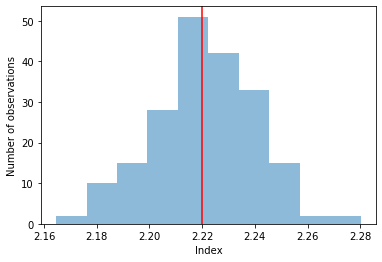

In [15]:
index = np.array([_["index"] for _ in results])
plt.hist(index, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["index"].value, color="red")
plt.xlabel('Index')
plt.ylabel('Number of observations')
print(f"index: {index.mean()} += {index.std()}")

amplitude: 1.2844615805590017e-12 += 4.214236797546734e-14


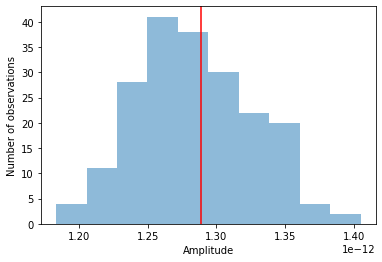

In [16]:
amplitude = np.array([_["amplitude"] for _ in results])
plt.hist(amplitude, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["amplitude"].value, color="red")
plt.xlabel('Amplitude')
plt.ylabel('Number of observations')
print(f"amplitude: {amplitude.mean()} += {amplitude.std()}")

In [17]:
reference = np.array([_["reference"] for _ in results])
x = np.array([index, amplitude, reference])
covar=np.cov(x)
print(covar)

[[ 3.84343872e-04 -2.49891537e-16  0.00000000e+00]
 [-2.49891537e-16  1.78490370e-27  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]


In [18]:
simu = PowerLawSpectralModel(
    index=index.mean(),
    amplitude=amplitude.mean() * u.Unit("cm-2 s-1 TeV-1"),
    reference=1 * u.TeV,
)
print(simu)

PowerLawSpectralModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.221e+00   nan                nan nan  False
amplitude 1.284e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True


In [19]:
i = 0
fpes[i].table_formatted

e_ref,e_min,e_max,ref_dnde,ref_flux,ref_eflux,ref_e2dnde,norm,stat,norm_err,counts [1],norm_errp,norm_errn,norm_ul,sqrt_ts,ts,norm_scan [11],stat_scan [11],dnde,dnde_ul,dnde_err,dnde_errp,dnde_errn
TeV,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),,,,,,,,,,,,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV)
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.049,0.032,0.077,1.102e-09,5.130e-11,2.420e-12,2.698e-12,1.015,0.000,0.103,1766,0.103,0.102,1.222,10.542,111.128,0.200 .. 5.000,69.784 .. 1008.406,1.118e-09,1.347e-09,1.131e-10,1.137e-10,1.125e-10
0.121,0.077,0.190,1.507e-10,1.718e-11,1.984e-12,2.213e-12,1.043,0.000,0.066,1076,0.067,0.066,1.178,18.335,336.174,0.200 .. 5.000,206.314 .. 1768.829,1.572e-10,1.776e-10,9.985e-12,1.007e-11,9.898e-12
0.297,0.190,0.464,2.062e-11,5.754e-12,1.627e-12,1.814e-12,0.910,0.000,0.059,538,0.060,0.058,1.031,19.623,385.055,0.200 .. 5.000,208.087 .. 1781.040,1.876e-11,2.126e-11,1.218e-12,1.234e-12,1.203e-12
0.726,0.464,1.136,2.820e-12,1.927e-12,1.334e-12,1.488e-12,0.962,0.000,0.069,273,0.071,0.068,1.107,20.069,402.779,0.200 .. 5.000,210.764 .. 1115.353,2.714e-12,3.122e-12,1.958e-13,1.999e-13,1.919e-13
1.778,1.136,2.783,3.858e-13,6.454e-13,1.094e-12,1.220e-12,1.137,0.000,0.080,225,0.082,0.078,1.304,23.491,551.822,0.200 .. 5.000,301.453 .. 804.715,4.386e-13,5.031e-13,3.086e-14,3.157e-14,3.017e-14
4.354,2.783,6.813,5.277e-14,2.161e-13,8.972e-13,1.000e-12,1.049,0.000,0.096,129,0.099,0.093,1.253,18.667,348.442,0.200 .. 5.000,176.840 .. 542.712,5.537e-14,6.611e-14,5.056e-15,5.233e-15,4.886e-15
10.661,6.813,16.681,7.218e-15,7.239e-14,7.357e-13,8.202e-13,0.990,0.000,0.141,51,0.148,0.135,1.300,12.472,155.548,0.200 .. 5.000,73.342 .. 242.490,7.149e-15,9.379e-15,1.019e-15,1.067e-15,9.717e-16
26.102,16.681,40.842,9.872e-16,2.424e-14,6.033e-13,6.726e-13,0.494,0.000,0.165,9,0.184,0.147,0.901,5.679,32.252,0.200 .. 5.000,5.573 .. 122.367,4.881e-16,8.896e-16,1.627e-16,1.813e-16,1.451e-16


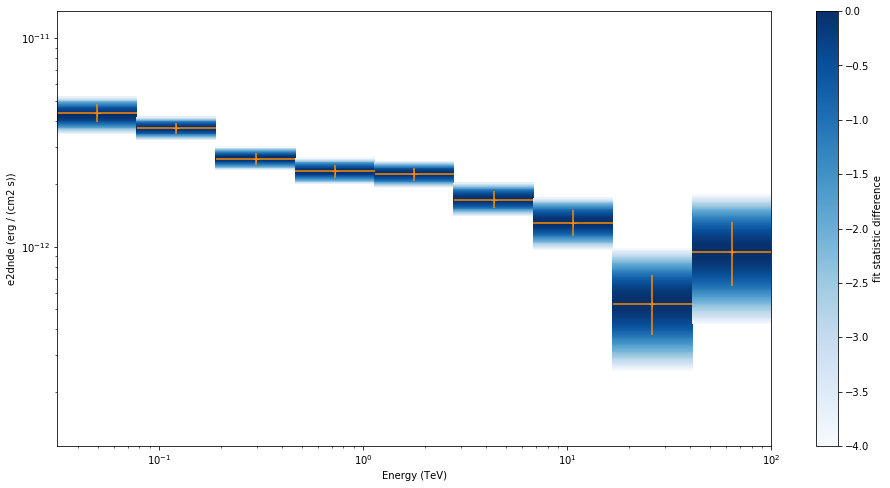

In [20]:
plt.figure(figsize=(16, 8))
fpes[i].table["is_ul"] = fpes[i].table["ts"] < 4
ax = fpes[i].plot(
    energy_power=2, flux_unit="erg-1 cm-2 s-1", color="darkorange"
)
fpes[i].to_sed_type("e2dnde").plot_ts_profiles(ax=ax)

In [21]:
flux_points_dataset = FluxPointsDataset(
    data=fpes[i], models=model_best_joints[i]
)

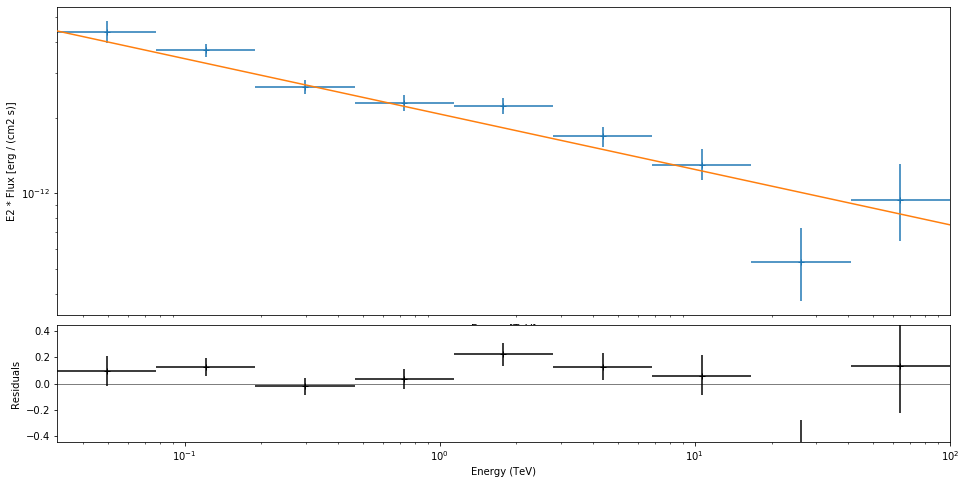

In [22]:
plt.figure(figsize=(16, 8))
flux_points_dataset.peek();

<function matplotlib.pyplot.show(*args, **kw)>

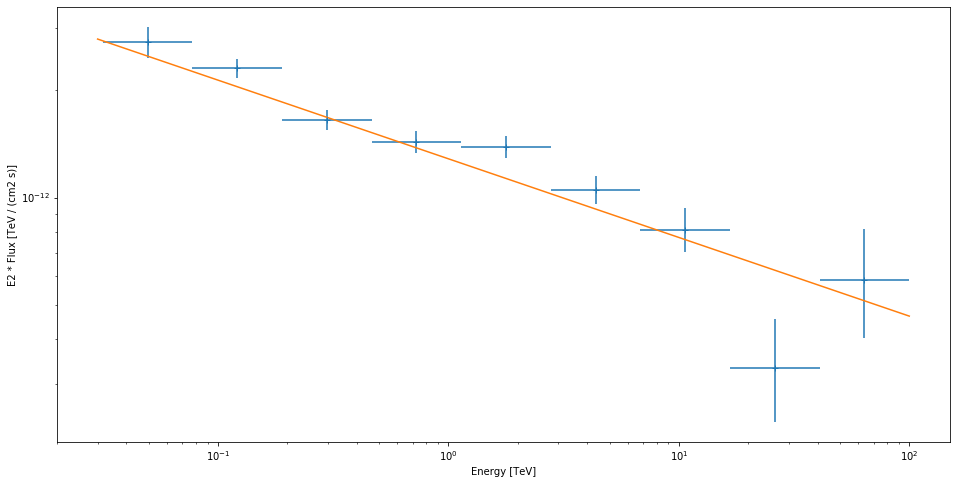

In [23]:
energy_range = [0.03, 100] * u.TeV
plt.figure(figsize=[16,8])
fpes[i].plot(energy_power=2)
simu.plot(energy_range=energy_range, energy_power=2)
plt.show

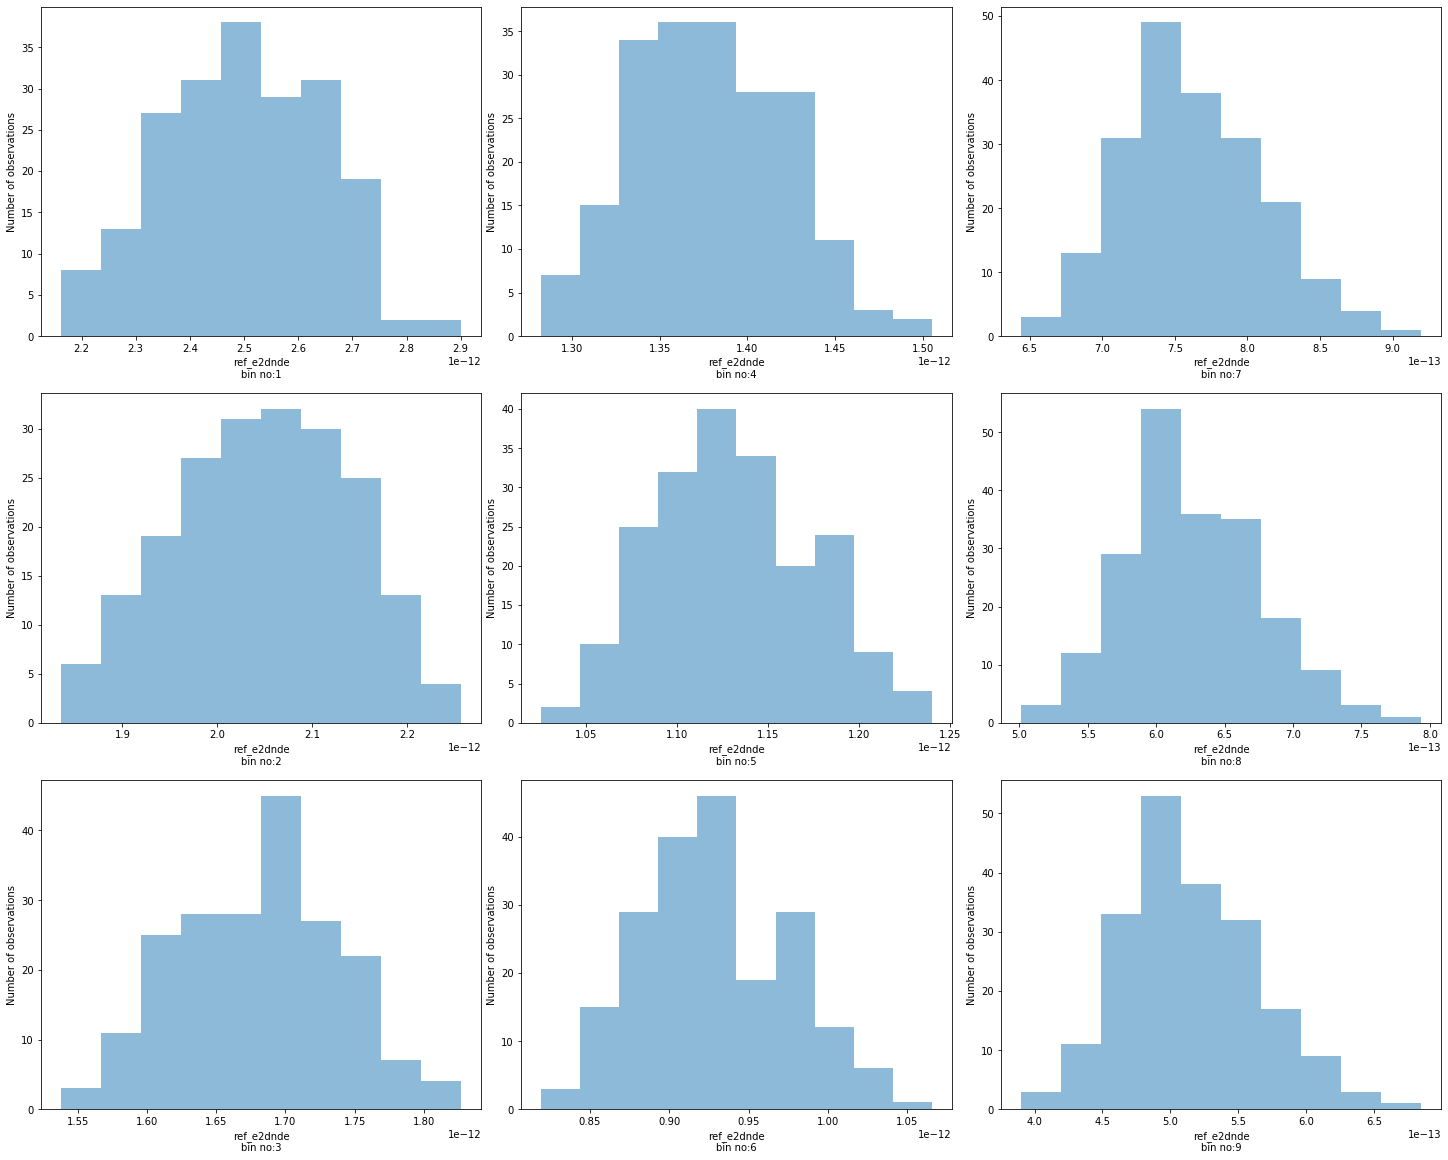

In [24]:
fig = plt.figure(figsize=[20,16],constrained_layout=True)

import matplotlib.gridspec as gridspec

gs0 = gridspec.GridSpec(1, 3, figure=fig)

gs1 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs0[0])
for n in range(3):
    ax = fig.add_subplot(gs1[n])
    e_ref_first = np.array([_.table['ref_e2dnde'][n] for _ in fpes])
    plt.hist(e_ref_first, bins=10, alpha=0.5)
    plt.xlabel(f'ref_e2dnde\nbin no:{n+1}')
    plt.ylabel('Number of observations')
    
gs2 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs0[1])
for n in range(3):
    ax = fig.add_subplot(gs2[n])
    e_ref_first = np.array([_.table['ref_e2dnde'][n+3] for _ in fpes])
    plt.hist(e_ref_first, bins=10, alpha=0.5)
    plt.xlabel(f'ref_e2dnde\nbin no:{n+4}')
    plt.ylabel('Number of observations')

gs3 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs0[2])
for n in range(3):
    ax = fig.add_subplot(gs3[n])
    e_ref_first = np.array([_.table['ref_e2dnde'][n+6] for _ in fpes])
    plt.hist(e_ref_first, bins=10, alpha=0.5)
    plt.xlabel(f'ref_e2dnde\nbin no:{n+7}')
    plt.ylabel('Number of observations')

plt.show()

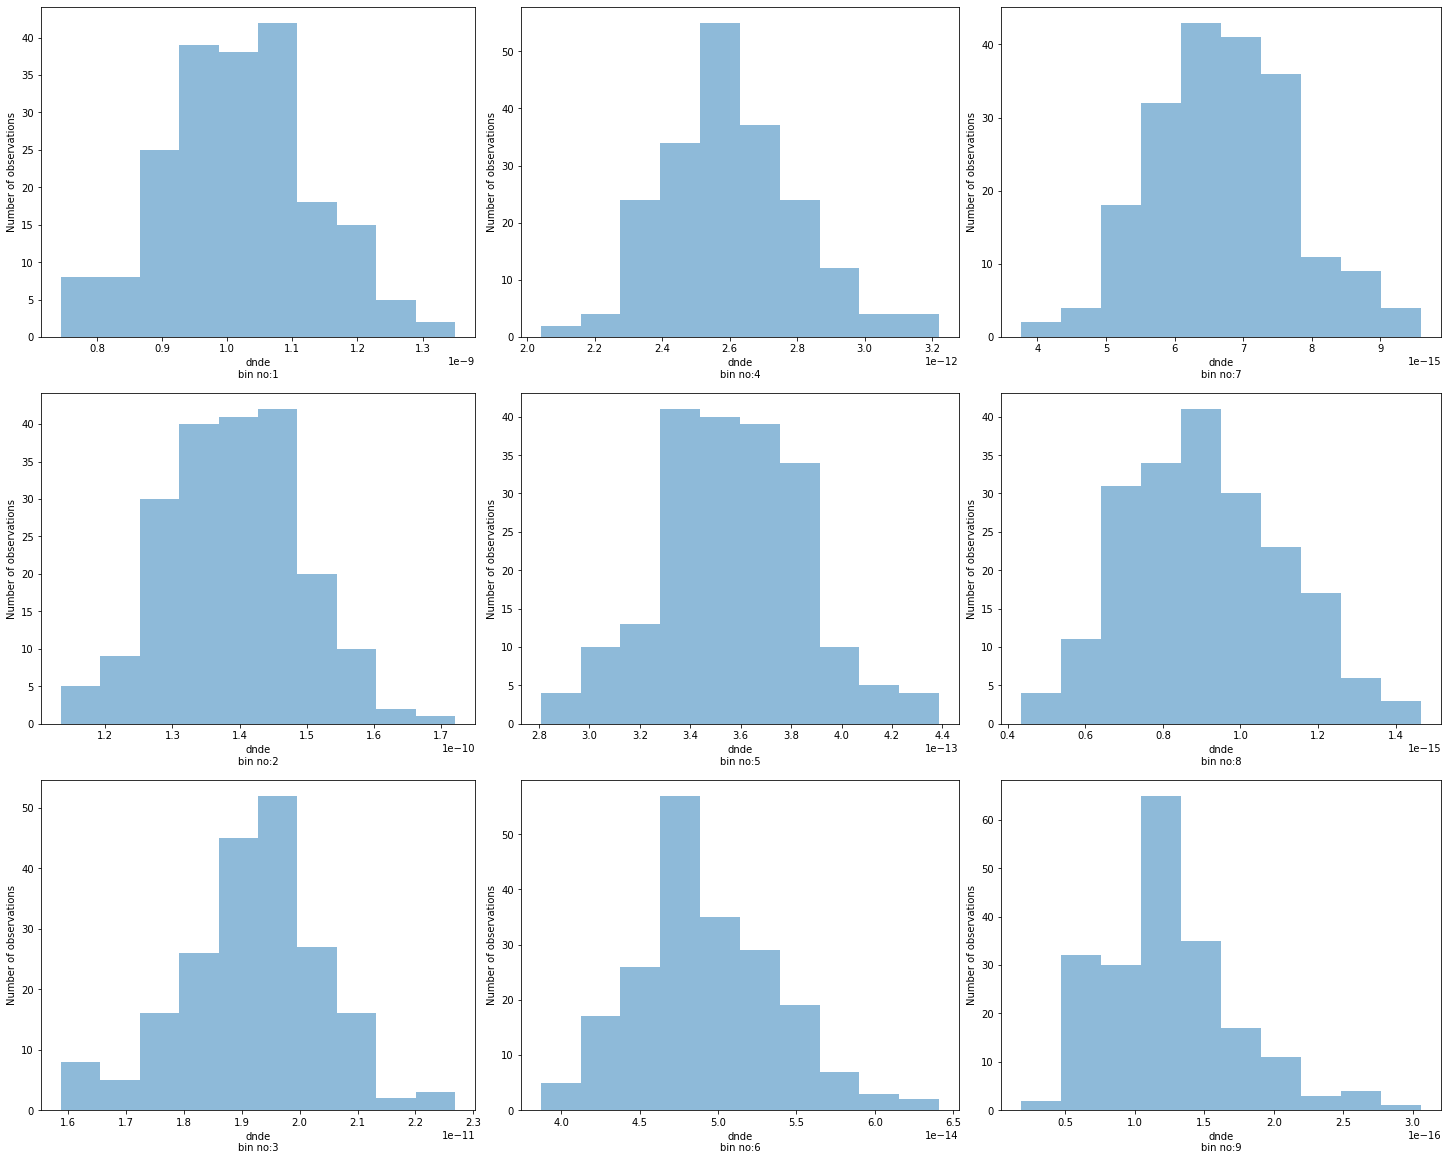

In [25]:
fig = plt.figure(figsize=[20,16],constrained_layout=True)

import matplotlib.gridspec as gridspec

gs0 = gridspec.GridSpec(1, 3, figure=fig)

gs1 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs0[0])
for n in range(3):
    ax = fig.add_subplot(gs1[n])
    e_ref_first = np.array([_.table['dnde'][n] for _ in fpes])
    plt.hist(e_ref_first, bins=10, alpha=0.5)
    plt.xlabel(f'dnde\nbin no:{n+1}')
    plt.ylabel('Number of observations')
    
gs2 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs0[1])
for n in range(3):
    ax = fig.add_subplot(gs2[n])
    e_ref_first = np.array([_.table['dnde'][n+3] for _ in fpes])
    plt.hist(e_ref_first, bins=10, alpha=0.5)
    plt.xlabel(f'dnde\nbin no:{n+4}')
    plt.ylabel('Number of observations')

gs3 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs0[2])
for n in range(3):
    ax = fig.add_subplot(gs3[n])
    e_ref_first = np.array([_.table['dnde'][n+6] for _ in fpes])
    plt.hist(e_ref_first, bins=10, alpha=0.5)
    plt.xlabel(f'dnde\nbin no:{n+7}')
    plt.ylabel('Number of observations')

plt.show()

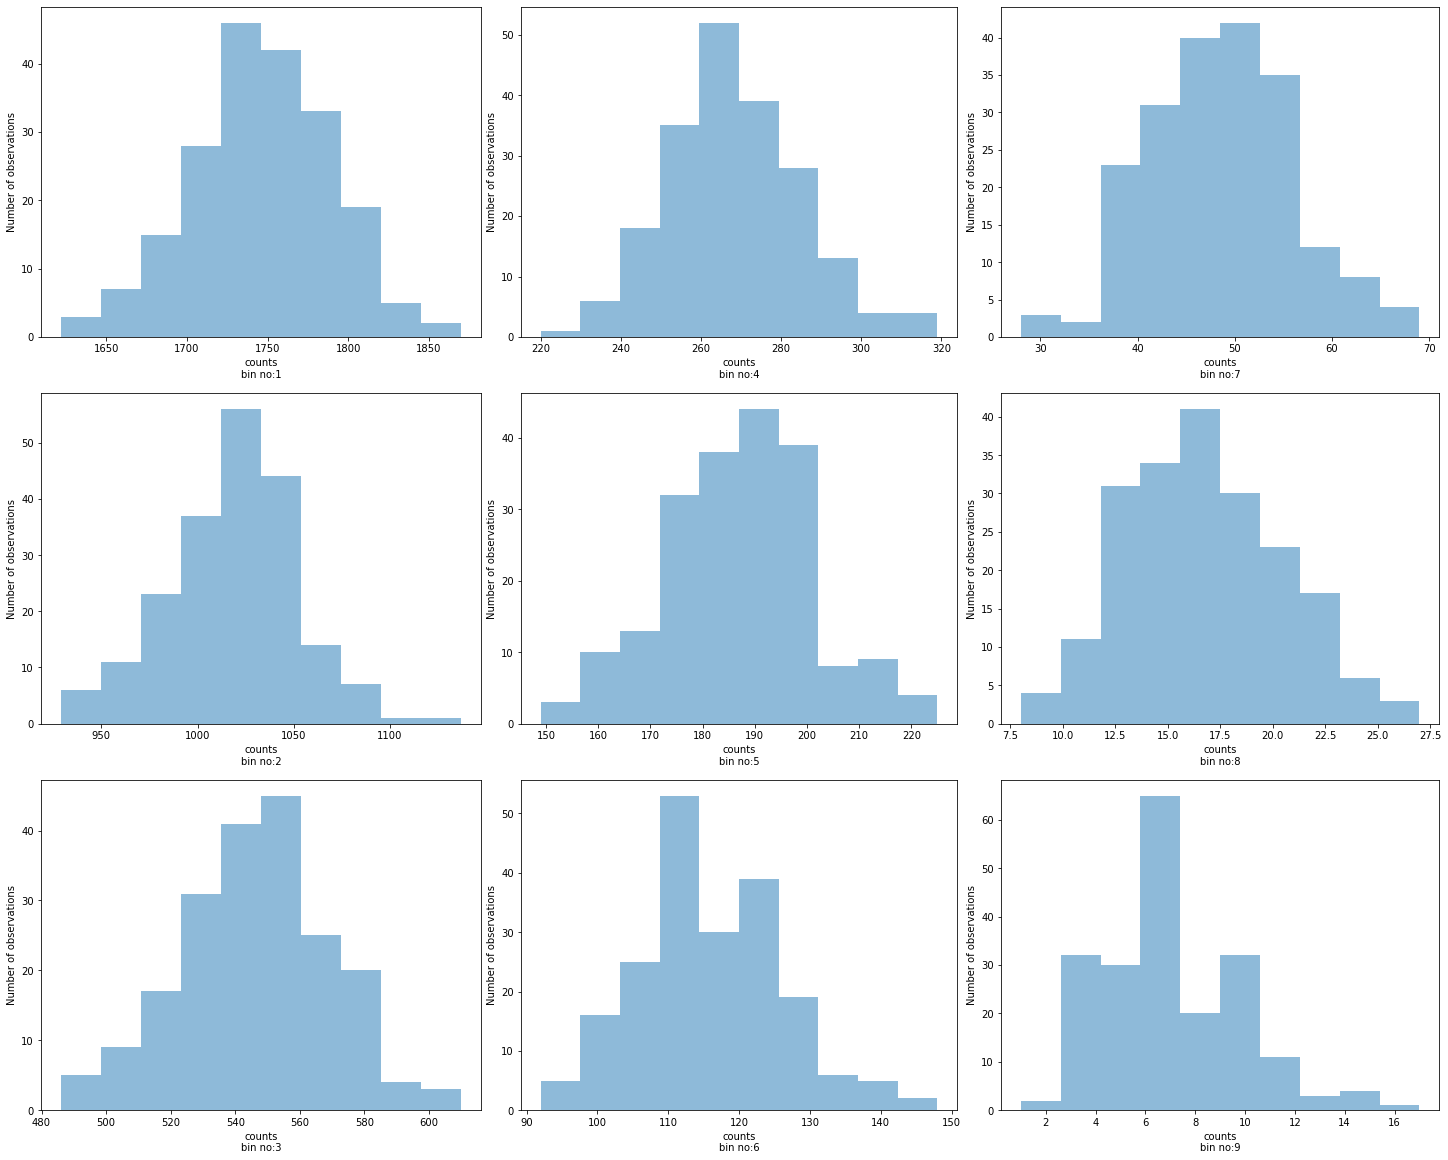

In [26]:
fig = plt.figure(figsize=[20,16],constrained_layout=True)

import matplotlib.gridspec as gridspec

gs0 = gridspec.GridSpec(1, 3, figure=fig)

gs1 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs0[0])
for n in range(3):
    ax = fig.add_subplot(gs1[n])
    e_ref_first = np.array([_.table['counts'][n] for _ in fpes])
    plt.hist(e_ref_first, bins=10, alpha=0.5)
    plt.xlabel(f'counts\nbin no:{n+1}')
    plt.ylabel('Number of observations')
    
gs2 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs0[1])
for n in range(3):
    ax = fig.add_subplot(gs2[n])
    e_ref_first = np.array([_.table['counts'][n+3] for _ in fpes])
    plt.hist(e_ref_first, bins=10, alpha=0.5)
    plt.xlabel(f'counts\nbin no:{n+4}')
    plt.ylabel('Number of observations')

gs3 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs0[2])
for n in range(3):
    ax = fig.add_subplot(gs3[n])
    e_ref_first = np.array([_.table['counts'][n+6] for _ in fpes])
    plt.hist(e_ref_first, bins=10, alpha=0.5)
    plt.xlabel(f'counts\nbin no:{n+7}')
    plt.ylabel('Number of observations')

plt.show()

In [27]:
x = ['e_ref','e_min','e_max','ref_dnde','ref_flux','ref_eflux','ref_e2dnde','norm','stat','norm_err','norm_errp','norm_errn','norm_ul','sqrt_ts','ts','norm_scan','stat_scan','dnde','dnde_ul','dnde_err','dnde_errp','dnde_errn']

In [28]:
flux_points_mean = fpe.run()
flux_points_mean.table_formatted

e_ref,e_min,e_max,ref_dnde,ref_flux,ref_eflux,ref_e2dnde,norm,stat,norm_err,counts [1],norm_errp,norm_errn,norm_ul,sqrt_ts,ts,norm_scan [11],stat_scan [11],dnde,dnde_ul,dnde_err,dnde_errp,dnde_errn
TeV,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),,,,,,,,,,,,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV)
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.049,0.032,0.077,1.030e-09,4.788e-11,2.261e-12,2.521e-12,1.026,0.000,0.111,1784,0.111,0.110,1.249,9.833,96.687,0.200 .. 5.000,61.172 .. 886.930,1.056e-09,1.286e-09,1.139e-10,1.142e-10,1.136e-10
0.121,0.077,0.190,1.425e-10,1.623e-11,1.876e-12,2.092e-12,0.940,0.000,0.068,1001,0.069,0.067,1.079,15.840,250.920,0.200 .. 5.000,146.357 .. 1745.150,1.340e-10,1.537e-10,9.681e-12,9.763e-12,9.600e-12
0.297,0.190,0.464,1.973e-11,5.499e-12,1.556e-12,1.736e-12,0.966,0.000,0.063,551,0.063,0.062,1.094,19.573,383.104,0.200 .. 5.000,215.728 .. 1622.539,1.905e-11,2.158e-11,1.235e-12,1.248e-12,1.223e-12
0.726,0.464,1.136,2.730e-12,1.864e-12,1.292e-12,1.440e-12,1.180,0.000,0.078,319,0.079,0.076,1.340,22.300,497.305,0.200 .. 5.000,294.220 .. 928.627,3.220e-12,3.659e-12,2.117e-13,2.155e-13,2.079e-13
1.778,1.136,2.783,3.779e-13,6.316e-13,1.072e-12,1.195e-12,0.966,0.000,0.075,189,0.077,0.073,1.124,20.965,439.539,0.200 .. 5.000,215.164 .. 882.460,3.653e-13,4.248e-13,2.834e-14,2.910e-14,2.760e-14
4.354,2.783,6.813,5.231e-14,2.140e-13,8.893e-13,9.917e-13,0.953,0.000,0.092,117,0.096,0.089,1.149,17.302,299.368,0.200 .. 5.000,142.156 .. 572.338,4.983e-14,6.010e-14,4.825e-15,4.997e-15,4.658e-15
10.661,6.813,16.681,7.241e-15,7.254e-14,7.379e-13,8.229e-13,0.925,0.000,0.137,48,0.143,0.130,1.225,11.862,140.711,0.200 .. 5.000,63.072 .. 253.496,6.700e-15,8.873e-15,9.897e-16,1.037e-15,9.431e-16
26.102,16.681,40.842,1.002e-15,2.458e-14,6.123e-13,6.828e-13,0.975,0.000,0.230,18,0.248,0.212,1.510,8.031,64.503,0.200 .. 5.000,28.417 .. 89.741,9.772e-16,1.513e-15,2.303e-16,2.490e-16,2.125e-16


In [30]:
for _ in x:
    y = 0
    for bin in fpes:
        y = y + bin.table[_]
    y = y/len(fpes)
    flux_points_mean.table[_] = y
    
y = 0
for bin in fpes:
    y = y + bin.table['counts']
y = y/len(fpes)
flux_points_mean.table['counts'] = y.astype(int)

In [31]:
flux_points_mean.table_formatted

e_ref,e_min,e_max,ref_dnde,ref_flux,ref_eflux,ref_e2dnde,norm,stat,norm_err,counts [1],norm_errp,norm_errn,norm_ul,sqrt_ts,ts,norm_scan [11],stat_scan [11],dnde,dnde_ul,dnde_err,dnde_errp,dnde_errn
TeV,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),,,,,,,,,,,,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV)
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.049,0.032,0.077,1.020e-09,4.751e-11,2.241e-12,2.499e-12,0.999,0.000,0.111,1746,0.111,0.110,1.223,9.594,93.162,0.200 .. 5.000,58.465 .. 899.651,1.020e-09,1.248e-09,1.126e-10,1.133e-10,1.120e-10
0.121,0.077,0.190,1.396e-10,1.591e-11,1.837e-12,2.049e-12,0.998,0.000,0.070,1019,0.070,0.069,1.140,16.412,270.589,0.200 .. 5.000,163.266 .. 1645.567,1.393e-10,1.591e-10,9.745e-12,9.819e-12,9.672e-12
0.297,0.190,0.464,1.909e-11,5.329e-12,1.507e-12,1.680e-12,1.004,0.000,0.064,546,0.065,0.064,1.136,19.953,399.272,0.200 .. 5.000,229.807 .. 1538.120,1.917e-11,2.168e-11,1.227e-12,1.241e-12,1.213e-12
0.726,0.464,1.136,2.613e-12,1.785e-12,1.236e-12,1.378e-12,0.998,0.000,0.074,268,0.076,0.073,1.153,19.062,364.693,0.200 .. 5.000,198.044 .. 999.029,2.609e-12,3.013e-12,1.944e-13,1.984e-13,1.905e-13
1.778,1.136,2.783,3.577e-13,5.984e-13,1.015e-12,1.131e-12,0.998,0.000,0.079,187,0.081,0.077,1.164,20.226,410.245,0.200 .. 5.000,208.450 .. 815.370,3.571e-13,4.162e-13,2.818e-14,2.891e-14,2.747e-14
4.354,2.783,6.813,4.899e-14,2.006e-13,8.329e-13,9.287e-13,1.004,0.000,0.098,115,0.101,0.095,1.213,17.092,293.376,0.200 .. 5.000,146.087 .. 518.281,4.919e-14,5.938e-14,4.793e-15,4.949e-15,4.641e-15
10.661,6.813,16.681,6.710e-15,6.729e-14,6.840e-13,7.626e-13,1.000,0.000,0.148,48,0.156,0.141,1.325,11.572,135.307,0.200 .. 5.000,66.294 .. 223.663,6.711e-15,8.891e-15,9.923e-16,1.041e-15,9.446e-16
26.102,16.681,40.842,9.194e-16,2.257e-14,5.618e-13,6.264e-13,0.985,0.000,0.240,16,0.261,0.221,1.548,7.690,59.934,0.200 .. 5.000,27.420 .. 82.505,9.071e-16,1.423e-15,2.203e-16,2.391e-16,2.024e-16


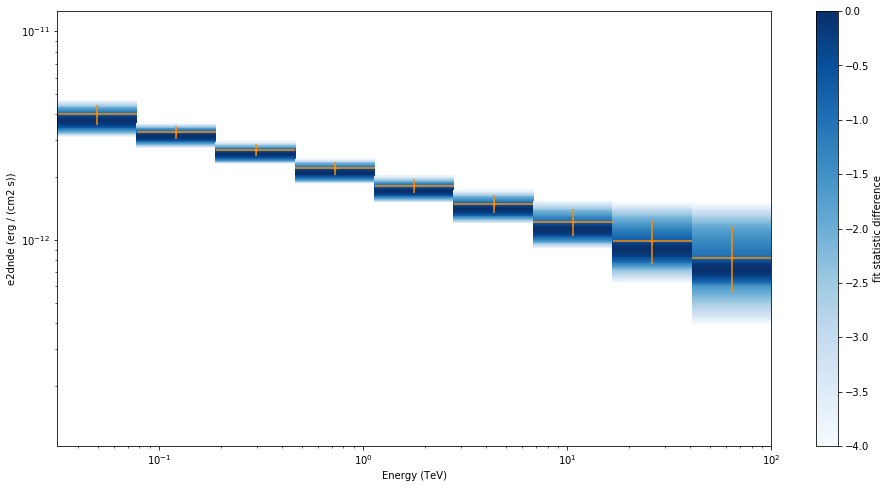

In [32]:
plt.figure(figsize=(16, 8))
flux_points_mean.table["is_ul"] = flux_points_mean.table["ts"] < 4
ax = flux_points_mean.plot(
    energy_power=2, flux_unit="erg-1 cm-2 s-1", color="darkorange"
)
flux_points_mean.to_sed_type("e2dnde").plot_ts_profiles(ax=ax)

In [33]:
flux_points_dataset = FluxPointsDataset(
    data=flux_points_mean, models=model_best_joints[124]
)

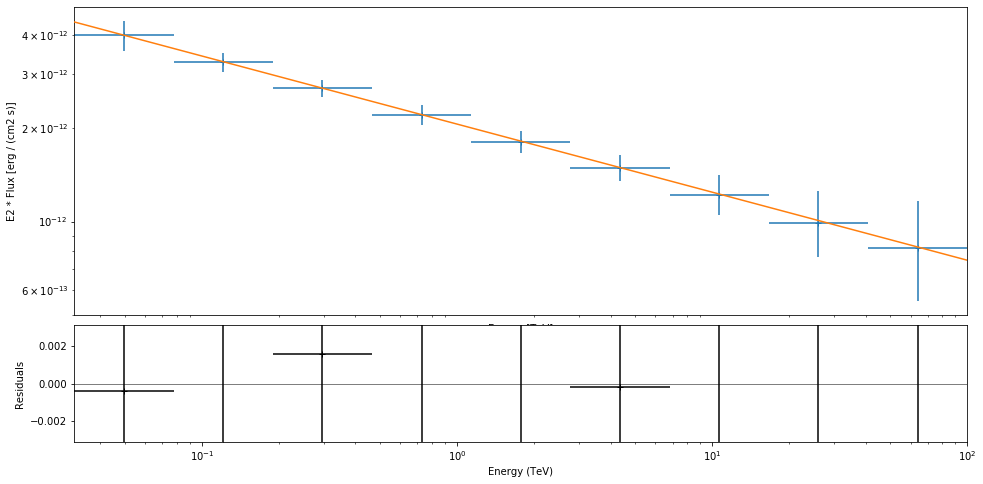

In [34]:
plt.figure(figsize=(16, 8))
flux_points_dataset.peek();

<function matplotlib.pyplot.show(*args, **kw)>

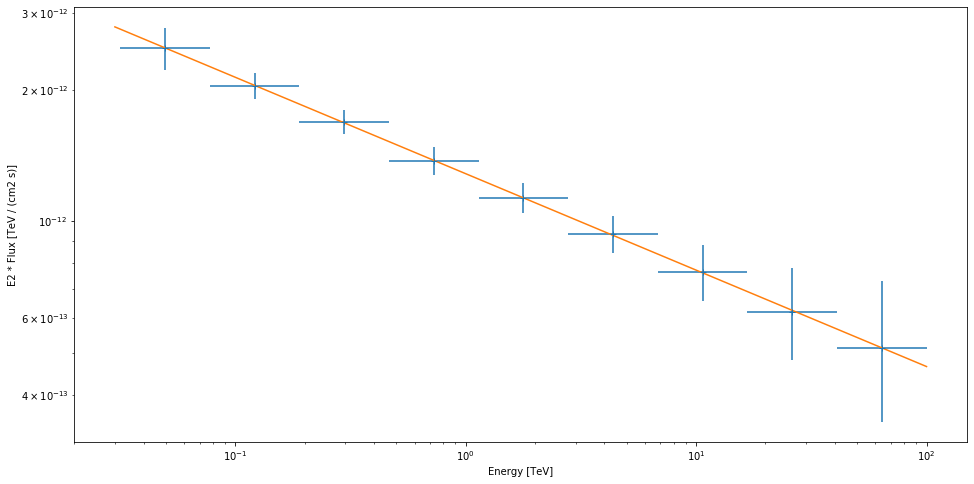

In [35]:
plt.figure(figsize=[16,8])
flux_points_mean.plot(energy_power=2)
simu.plot(energy_range=energy_range, energy_power=2)
plt.show

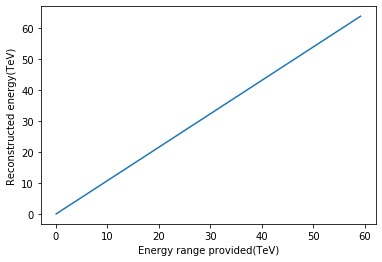

In [36]:
plt.plot(energy_axis.bin_width, flux_points_mean.table['e_ref'])

plt.xlabel('Energy range provided(TeV)')
plt.ylabel('Reconstructed energy(TeV)')

plt.show()

In [37]:
fp = FluxPointsEstimator(datasets=datasets, e_edges=e_edges)
flu_pois = fp.run()

In [38]:
flu_pois.table_formatted

e_ref,e_min,e_max,ref_dnde,ref_flux,ref_eflux,ref_e2dnde,norm,stat,norm_err,counts [200],norm_errp,norm_errn,norm_ul,sqrt_ts,ts,norm_scan [11],stat_scan [11],dnde,dnde_ul,dnde_err,dnde_errp,dnde_errn
TeV,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),,,,,,,,,,,,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV)
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.049,0.032,0.077,1.102e-09,5.130e-11,2.420e-12,2.698e-12,0.925,212.110,0.007,1766 .. 1784,0.007,0.007,0.940,135.721,18420.309,0.200 .. 5.000,11238.474 .. 210734.301,1.020e-09,1.035e-09,7.965e-12,7.968e-12,7.962e-12
0.121,0.077,0.190,1.507e-10,1.718e-11,1.984e-12,2.213e-12,0.924,218.751,0.005,1076 .. 1001,0.005,0.005,0.933,232.162,53899.140,0.200 .. 5.000,31258.840 .. 379714.865,1.393e-10,1.406e-10,6.891e-13,6.896e-13,6.887e-13
0.297,0.190,0.464,2.062e-11,5.754e-12,1.627e-12,1.814e-12,0.930,194.774,0.004,538 .. 551,0.004,0.004,0.938,282.240,79659.555,0.200 .. 5.000,43809.656 .. 351894.955,1.917e-11,1.934e-11,8.678e-14,8.673e-14,8.683e-14
0.726,0.464,1.136,2.820e-12,1.927e-12,1.334e-12,1.488e-12,0.925,211.409,0.005,273 .. 319,0.005,0.005,0.935,269.680,72727.156,0.200 .. 5.000,37588.375 .. 227407.563,2.609e-12,2.637e-12,1.375e-14,1.377e-14,1.374e-14
1.778,1.136,2.783,3.858e-13,6.454e-13,1.094e-12,1.220e-12,0.926,203.904,0.005,225 .. 189,0.005,0.005,0.936,286.086,81845.089,0.200 .. 5.000,39326.422 .. 184930.140,3.571e-13,3.611e-13,1.994e-15,1.994e-15,1.995e-15
4.354,2.783,6.813,5.277e-14,2.161e-13,8.972e-13,1.000e-12,0.932,185.147,0.006,129 .. 117,0.006,0.006,0.945,241.847,58490.092,0.200 .. 5.000,27531.814 .. 117324.453,4.920e-14,4.988e-14,3.393e-16,3.394e-16,3.392e-16
10.661,6.813,16.681,7.218e-15,7.239e-14,7.357e-13,8.202e-13,0.930,222.552,0.010,51 .. 48,0.010,0.010,0.950,163.826,26838.884,0.200 .. 5.000,12501.400 .. 50500.838,6.713e-15,6.855e-15,7.036e-17,7.049e-17,7.024e-17
26.102,16.681,40.842,9.872e-16,2.424e-14,6.033e-13,6.726e-13,0.919,178.458,0.016,9 .. 18,0.016,0.016,0.951,108.667,11808.413,0.200 .. 5.000,5140.575 .. 18558.222,9.072e-16,9.389e-16,1.569e-17,1.574e-17,1.563e-17


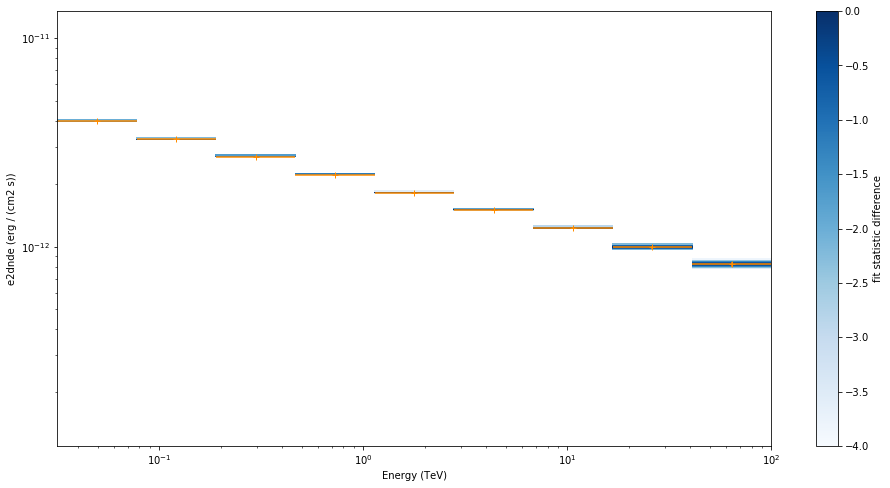

In [39]:
plt.figure(figsize=(16, 8))
flu_pois.table["is_ul"] = flu_pois.table["ts"] < 4
ax = flu_pois.plot(
    energy_power=2, flux_unit="erg-1 cm-2 s-1", color="darkorange"
)
flu_pois.to_sed_type("e2dnde").plot_ts_profiles(ax=ax)

In [40]:
flu_pois_dataset = FluxPointsDataset(
    data=flu_pois, models=model_best_joints[124]
)

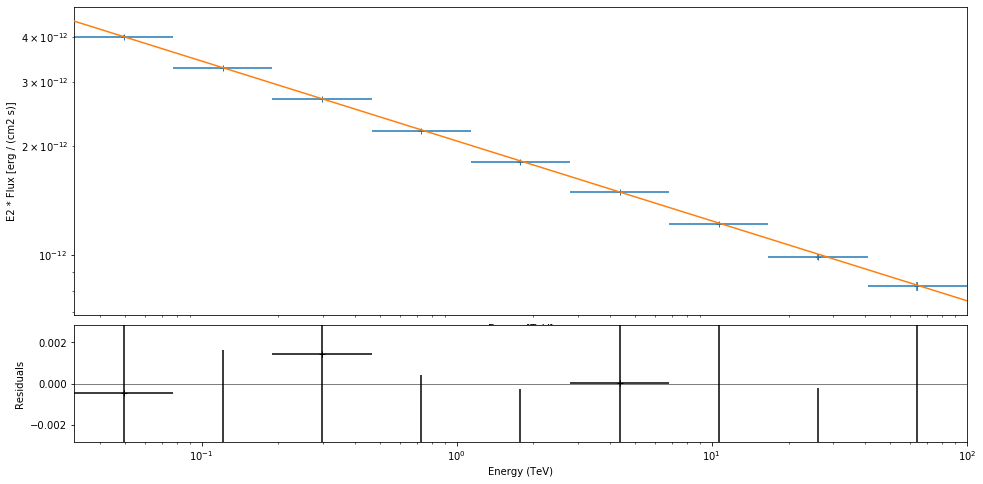

In [41]:
plt.figure(figsize=(16, 8))
flu_pois_dataset.peek();

<function matplotlib.pyplot.show(*args, **kw)>

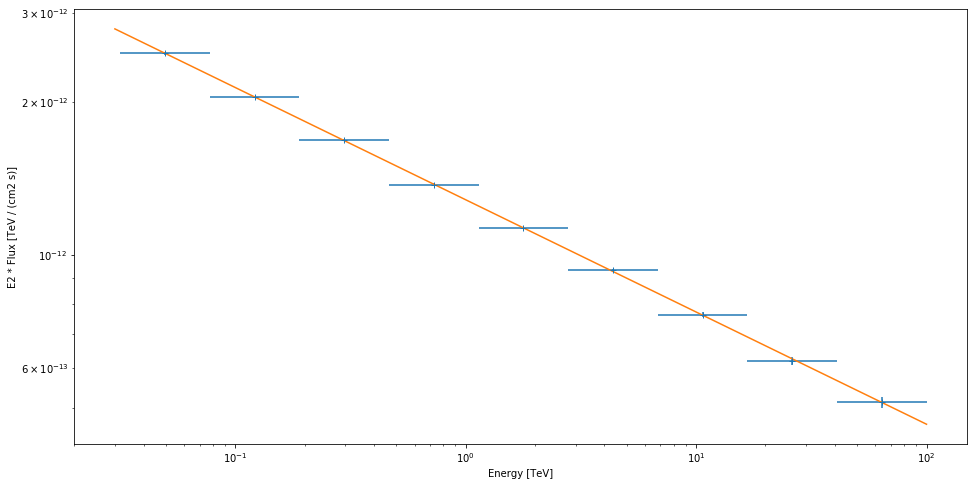

In [42]:
plt.figure(figsize=[16,8])
flu_pois.plot(energy_power=2)
simu.plot(energy_range=energy_range, energy_power=2)
plt.show